<a href="https://colab.research.google.com/github/M-orpheus/AcademicSun/blob/master/examples/tutorials/1_quickstart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ManiSkill Quick Start + Feature Showcase (BETA)

![](https://github.com/haosulab/ManiSkill/blob/main/figures/teaser.jpg?raw=true)

[ManiSkill](https://github.com/haosulab/ManiSkill) is a feature-rich, user-friendly GPU-accelerated robotics benchmark built on top of [SAPIEN](https://github.com/haosulab/sapien) that is quick and easy to install. ManiSkill is designed to provide accessible support for a wide array of applications from robot learning, learning from demonstrations, sim2real/real2sim, and more. See our [paper on ManiSkill3](https://arxiv.org/abs/2410.00425), the latest iteration of the open-source ManiSkill project, for more details. The teaser image above shows several environments rendered with in ManiSkill, with scene datasets sourced from AI2-THOR and ReplicaCAD.


This notebook serves as a go to place to experiment with several core features that ManiSkill offers without diving too deep into the technical details and excludes those that can't run on Google Colab (such as ray-tracing for photo-realistic rendering). For more technical details on how to build with ManiSkill, see our documentation: [https://maniskill.readthedocs.io/en/latest/user_guide/index.html](https://maniskill.readthedocs.io/en/latest/user_guide/index.html)


This notebooks covers:
1. How to run environments/tasks, modify them, record them, and teleoperate them. (GPU parallelized rendering of RGB-D data achieves 3000+ FPS on even Google Colab's free tier!)
2. Some simple state/visual based RL code/workflows leveraging the GPU accelreated simulator. Solve robotics tasks in minutes instead of hours/days!
3. Working with demonstration/offline data, how to load and replay and convert them
4. Heterogeneous Parallel Simulation. Showcasing simulating tasks where the number of objects or the articulations are completely different between each scene
5. Playing with more robots not included out of the box.
6. Running motion planning solutions to solve tasks.

There are also several [tutorials on our docs](https://maniskill.readthedocs.io/en/latest/user_guide/tutorials/) that cover details such as how to build custom tasks or how to add your own robots.

If you click the table of contents tab on the left, each major section can be run independently of the others so feel free to skip to whatever features you are interested in.


**NOTE:**
This project currently is in a **beta release**, so not all features have been added in yet and there may be some bugs. If you find any bugs or have any feature requests please post them to our [GitHub issues](https://github.com/haosulab/ManiSkill/issues/) or discuss about them on [GitHub discussions](https://github.com/haosulab/ManiSkill/discussions/). We also have a [Discord Server](https://discord.gg/x8yUZe5AdN) through which we make announcements and discuss about ManiSkill.


# Setup Code

To begin, prepare the colab environment by switching to a GPU environment (Runtime -> Change Runtime Type)

Then click the play button below. This will install all dependencies for the future code. ManiSkill only requires two pip packages (`maniskill` and `torch`) and setting up Vulkan. For those setting up their code locally you can check our [installation docs](https://maniskill.readthedocs.io/en/latest/user_guide/getting_started/installation.html)

In [2]:
# setup vulkan
!mkdir -p /usr/share/vulkan/icd.d
!wget -q https://raw.githubusercontent.com/haosulab/ManiSkill/main/docker/nvidia_icd.json
!wget -q https://raw.githubusercontent.com/haosulab/ManiSkill/main/docker/10_nvidia.json
!mv nvidia_icd.json /usr/share/vulkan/icd.d
!mv 10_nvidia.json /usr/share/glvnd/egl_vendor.d/10_nvidia.json
!apt-get install -y --no-install-recommends libvulkan-dev
# dependencies
!pip install --upgrade mani_skill tyro

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libvulkan1
Recommended packages:
  mesa-vulkan-drivers | vulkan-icd
The following NEW packages will be installed:
  libvulkan-dev libvulkan1
0 upgraded, 2 newly installed, 0 to remove and 41 not upgraded.
Need to get 1,020 kB of archives.
After this operation, 17.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libvulkan1 amd64 1.3.204.1-2 [128 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libvulkan-dev amd64 1.3.204.1-2 [892 kB]
Fetched 1,020 kB in 1s (702 kB/s)
Selecting previously unselected package libvulkan1:amd64.
(Reading database ... 121229 files and directories currently installed.)
Preparing to unpack .../libvulkan1_1.3.204.1-2_amd64.deb ...
Unpacking libvulkan1:amd64 (1.3.204.1-2) ...
Selecting previously unselected package libvulkan-dev:amd64.
Preparing to unpa

In [3]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    import site
    site.main() # run this so local pip installs are recognized

#1 Running the Environments (CPU/GPU)


ManiSkill follows the [OpenAI Gym / Gymnasium API](https://gymnasium.farama.org/) making it compatible with a wide range of libraries like those in RL. It is also designed to make task building flexible, simple, and pythonic. We provide a [tutorial on how to build custom tasks](https://maniskill.readthedocs.io/en/latest/user_guide/tutorials/custom_tasks/intro.html) on our documentation.


## 1.1 CPU Sim
During CPU simulation this API is followed completely and you can create an environment like so below.

Here we showcase the PegInsertionSide-v1 environment and how to run it. There are many other built-in environments documented at https://maniskill.readthedocs.io/en/latest/tasks/index.html

In [1]:
# Import required packages
import gymnasium as gym
import mani_skill.envs
import time
env = gym.make("PegInsertionSide-v1")
obs, _ = env.reset(seed=0)
env.unwrapped.print_sim_details() # print verbose details about the configuration
done = False
start_time = time.time()
while not done:
    obs, rew, terminated, truncated, info = env.step(env.action_space.sample())
    done = terminated or truncated
N = info["elapsed_steps"].item()
dt = time.time() - start_time
FPS = N / (dt)
print(f"Frames Per Second = {N} / {dt} = {FPS}")

# -------------------------------------------------------------------------- #
Task ID: PegInsertionSide-v1, 1 parallel environments, sim_backend=physx_cpu
obs_mode=state, control_mode=pd_joint_delta_pos
render_mode=None, sensor_details=RGBD(128x128), RGBD(128x128)
sim_freq=100, control_freq=20
observation space: Box(-inf, inf, (1, 43), float32)
(single) action space: Box(-1.0, 1.0, (8,), float32)
# -------------------------------------------------------------------------- #
Frames Per Second = 100 / 1.2102243900299072 = 82.62930479985516


You may also observe that all the data returned is a batched torch.Tensor. Generally everything inside ManiSkill is kept as batched torch tensors if possible, make it easy to support both CPU and GPU simulation. To have the expected gymnasium behavior (unbatched, numpy arrays) you can do the following

In [2]:
from mani_skill.utils.wrappers import CPUGymWrapper
env = gym.make("PegInsertionSide-v1")
env = CPUGymWrapper(env)
obs, _ = env.reset() # obs is numpy and unbatched
print(type(obs), obs.shape)

<class 'numpy.ndarray'> (43,)


To then render what it looks like you can use either `env.render`. Note that above we set the render_mode to be `"rgb_array"`, which is following the Gymnasium API and configures what `env.render` returns.

If the render_mode is set to `"sensors"` then it returns a rgb array showing the actual visual data you would receive if you choose a visual based observation mode.

If the render mode is `all` then this combines `"rgb_array"` and `"sensors"` modes.

If the render mode is set to `"human"` (the default) then it opens a GUI viewer that you can use to interact with the environment (requires a display).

The example below shows a very simple render of a simple environment. ManiSkill supports all kinds of rendering options when building environments (modifying lighting, shadows, textures, environment maps etc.).

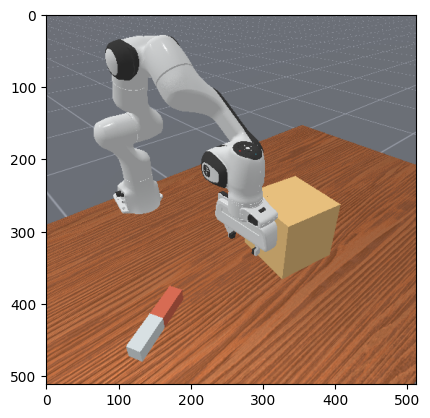

In [4]:
import matplotlib.pyplot as plt
env = gym.make("PegInsertionSide-v1", render_mode="rgb_array")
env.reset()
plt.imshow(env.render()[0].cpu().numpy()) # we take [0].numpy() as everything is a batched tensor

## 1.2 GPU (State-only)

Running the GPU simulation is as easy as setting the `num_envs` argument to a number > 1. On Colab's free tier (T4 GPU) you should be able to run up to 2048 parallel environments of the PickCube-v1 task and achieve around 20,000 FPS. You can also run multiple environments, which can be useful for ML workflows by keeping a training and evaluation environment. Note that simulation FPS is heavily dependent on the simulation and control frequencies, the objects in the scene, etc., so your FPS for your own environments can vary in a wide range.

During GPU parallelized simulation, nearly everything in ManiSkill is batched and a torch tensor by default. Moreover, due to how ManiSkill is structured with the underlying SAPIEN engine most tasks created are always simulatable on the CPU and GPU.

*Note that currently you cannot run a CPU simulation followed by a GPU simulation and vice versa. If you ran the cell above simply restart the notebook (shortcut is `ctrl+M+.`)*

*Note that there is currently a bug that only appears on Colab where GPU resources do not get released after closing GPU sim environments. The fix for now is to simply restart the notebook*

In [ ]:
### Make sure to restart the notebook if you already ran a CPU sim!! ###
# Import required packages
import gymnasium as gym
import mani_skill.envs
import torch
import time
num_envs = 2048 # you can go up to 4096 on better GPUs
env = gym.make("PickCube-v1", num_envs=num_envs)
env.unwrapped.print_sim_details()
obs, _ = env.reset(seed=0)
done = False
start_time = time.time()
total_rew = 0
while not done:
    # note that env.action_space is now a batched action space
    obs, rew, terminated, truncated, info = env.step(torch.from_numpy(env.action_space.sample()))
    done = (terminated | truncated).any() # stop if any environment terminates/truncates
N = num_envs * info["elapsed_steps"][0].item()
dt = time.time() - start_time
FPS = N / (dt)
print(f"Frames Per Second = {N} / {dt} = {FPS}")

## 1.3 GPU (State+Visual)

A key feature of ManiSkill and SAPIEN is the ability to render in parallel, allowing for extremely high FPS for visual rendering, which can be incredibly useful for computer vision workflows and visual RL. On Colab's free tier (T4 GPU) you should be able to run 512 parallel environments of the PickCube-v1 task and achieve around 3500FPS when sampling random actions

In [ ]:
# Import required packages
import gymnasium as gym
import mani_skill.envs
import torch
import time
num_envs = 512 # you can go up higher on better GPUs, this is mostly memory constrained
env = gym.make("PickCube-v1", num_envs=num_envs, obs_mode="rgbd")
env.unwrapped.print_sim_details()
obs, _ = env.reset(seed=0)
done = False
start_time = time.time()
total_rew = 0
while not done:
    # note that env.action_space is now a batched action space
    obs, rew, terminated, truncated, info = env.step(torch.from_numpy(env.action_space.sample()))
    done = (terminated | truncated).any() # stop if any environment terminates/truncates
N = num_envs * info["elapsed_steps"][0].item()
dt = time.time() - start_time
FPS = N / (dt)
print(f"Frames Per Second = {N} / {dt} = {FPS}")

In [ ]:
# visualize the image data from the environment and inspect the data
print(obs.keys())
print(obs['sensor_data'].keys())
print(obs['sensor_data']['base_camera'].keys())
print(obs['sensor_data']['base_camera']['rgb'].shape)
import matplotlib.pyplot as plt
plt.imshow(obs['sensor_data']['base_camera']['rgb'][0].cpu().numpy())

## 1.4 Changing the Environment's Observations and Controllers

ManiSkill flexibly supports several **observation modes (state and visual)** as well as changing the **controller** used to control the robots in the simulation. Furthermore the reward mode and even the robot itself can flexibly be changed. Documentation on observations and controllers can be found [here](https://maniskill.readthedocs.io/en/latest/user_guide/concepts/controllers.html).

Controller design is important when it comes to problems of sim2real transfer so ManiSkill has built-in support for robot implementations to have multiple controllers.

We will demonstrate these on the GPU sim.

In [ ]:
# Import required packages
import gymnasium as gym
from tqdm.notebook import tqdm
import numpy as np
import mani_skill.envs
import matplotlib.pyplot as plt

In [ ]:
#@markdown Run this cell to display the action space of the chosen controller as well as the current view of the environment
# Can be any env_id from the list of Rigid-Body envs: https://maniskill.readthedocs.io/en/latest/tasks/index.html
env_id = "PickCube-v1" #@param ['PickCube-v1', 'PegInsertionSide-v1', 'StackCube-v1']

# choose an observation type and space, see https://maniskill.readthedocs.io/en/latest/user_guide/concepts/observation.html for details
obs_mode = "rgb+depth+segmentation" #@param can be one of ['pointcloud', 'rgb+depth+segmentation', 'state_dict', 'state']

# choose a controller type / action space, see https://maniskill.readthedocs.io/en/latest/user_guide/concepts/controllers.html for a full list
control_mode = "pd_joint_delta_pos" #@param can be one of ['pd_ee_delta_pose', 'pd_ee_delta_pos', 'pd_joint_delta_pos', 'arm_pd_joint_pos_vel']

reward_mode = "dense" #@param can be one of ['sparse', 'dense']

robot_uids = "panda" #@param can be one of ['panda', 'fetch']

# create an environment with our configs and then reset to a clean state
env = gym.make(env_id,
               num_envs=4,
               obs_mode=obs_mode,
               reward_mode=reward_mode,
               control_mode=control_mode,
               robot_uids=robot_uids,
               enable_shadow=True # this makes the default lighting cast shadows
               )
obs, _ = env.reset()
print("Action Space:", env.action_space)

# take a look at the current state of the 4 parallel environments we created
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
rgbs = env.render_rgb_array() # this is a easy way to get the rgb array without having to set render_mode
for i, ax in enumerate(axs.flatten()):
    ax.imshow(rgbs[i].cpu().numpy())
    ax.axis("off")
plt.suptitle("Current States viewed from external cameras")
fig.tight_layout()
env.close()

In [ ]:
# some visualization functions for different observation modes
def show_camera_view(obs_camera, title, env_id=0):
    plt.figure()
    rgb, depth = obs_camera['rgb'], obs_camera['depth']
    plt.subplot(1,3,1)
    plt.title(f"{title} - RGB")
    plt.imshow(rgb[env_id].cpu().numpy())
    plt.subplot(1,3,2)
    plt.title(f"{title} - Depth")
    plt.imshow(depth[..., 0][env_id].cpu().numpy(), cmap="gray")
    plt.subplot(1,3,3)
    plt.title(f"{title} - Segmentation")
    plt.imshow(obs_camera["segmentation"][..., 0][env_id].cpu().numpy())

def show_pointcloud(obs, env_id=0):
    import trimesh
    v = obs['pointcloud']['xyzw'][env_id, ..., :3].cpu().numpy()
    cam2world = obs["sensor_param"]["base_camera"]["cam2world_gl"][env_id].cpu().numpy()
    cam2world = cam2world
    camera = trimesh.scene.Camera("camera", (1024, 1024), fov=(np.rad2deg(np.pi/2), np.rad2deg(np.pi/2)))
    s = trimesh.Scene([trimesh.points.PointCloud(v, obs['pointcloud']['rgb'][env_id].cpu().numpy())], camera=camera, camera_transform=cam2world)
    return s.show()

In [ ]:
#@markdown Display the RGBD+Segmentation observation. Make sure you are using `obs_mode="rgbd"`
show_camera_view(obs['sensor_data']['base_camera'], "Base")

In [ ]:
#@markdown Display one of the Pointcloud observations. Make sure you are using `obs_mode="pointcloud"`
show_pointcloud(obs)

## 1.5 Interactive Viewer and Recording videos

To create a replay video of what happened in an episode, we can use the `RecordEpisode` environment wrapper shown below, and specify what we want to record.

`RecordEpisode` will always use what the `render_mode` specified at environment creation is, and in the code below we use "rgb_array" as shown earlier. "rgb_array" corresponds with RGB cameras and will render what they show. There is also the "sensors" render mode which shows a visualization of all sensor data (e.g. RGB and depth) together.

ManiSkill has an interactive viewer, available if you run locally on a machine with a GUI. You can render the current state with `env.render_human
()` which will bring up a viewer. The script below will show the interactive viewer if it detects that it is not running in Colab.

In [ ]:
# Import required packages
import gymnasium as gym
import torch
import mani_skill.envs
from tqdm.notebook import tqdm
from mani_skill.utils.wrappers import RecordEpisode
# to make it look a little more realistic, we will enable shadows which make the default lighting cast shadows
env = gym.make("PickCube-v1", num_envs=4, render_mode="rgb_array", enable_shadow=True)
env = RecordEpisode(
    env,
    "./videos", # the directory to save replay videos and trajectories to
    # on GPU sim we record intervals, not by single episodes as there are multiple envs
    # each 100 steps a new video is saved
    max_steps_per_video=100
)

# step through the environment with random actions
obs, _ = env.reset()
for i in tqdm(range(100)):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(torch.from_numpy(action))
    # env.render_human() # will render with a window if possible
env.close()
from IPython.display import Video
Video("./videos/0.mp4", embed=True, width=640) # Watch our replay

## 1.6 Teleoperation

To interactively control the robot, we plan to open-source a number of different tools to collect data, which include using VR systems, computer camera based systems, and more.


We currently provide a simple GUI-based tele-operation tool that lets you move the robot's end-effector around, toggle grasping, and make it follow your commands to solve tasks. More details about it can be found [here](https://maniskill.readthedocs.io/en/latest/user_guide/data_collection/teleoperation.html#click-drag-system). A video demonstrating how it works is shown below for the `StackCube-v1` task.

In [ ]:
!python -m mani_skill.examples.teleoperation.interactive_panda -e "StackCube-v1"

In [ ]:
%%html
<video controls width=800>
<source src="https://github.com/haosulab/ManiSkill/raw/main/docs/source/_static/videos/teleop-stackcube-demo.mp4">
</video>

#2 Reinforcement Learning

ManiSkill provides some simple baselines for reinforcement learning that can be run straight in google colab. The demo below solves some of the tasks from state and visual inputs and demonstrate just how quickly tasks can be solved with our GPU parallelized state/visual simulation. Documentation on all our baselines as well as how to evaluate models correctly in Maniskill can be found on our [RL documentation page](https://maniskill.readthedocs.io/en/latest/user_guide/reinforcement_learning/)

As RL code can be quite long, we refer users to read the code at https://github.com/haosulab/ManiSkill/tree/main/examples/baselines/ppo, an implementation of Proximal Policy Optimization adapted from [CleanRL](https://github.com/vwxyzjn/cleanrl/). In the future we will add support for other commonly used libraries.

To get started first download the RL code as done below and import some packages

In [ ]:
from IPython.display import Video

In [ ]:
!wget https://raw.githubusercontent.com/haosulab/ManiSkill/main/examples/baselines/ppo/ppo.py -O ppo.py
!wget https://raw.githubusercontent.com/haosulab/ManiSkill/main/examples/baselines/ppo/ppo_rgb.py -O ppo_rgb.py

The cell below opens tensorboard on colab so you can watch training metrics.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

### 2.1 State Based RL

The cell below runs the actual training code for state based RL, and should solve the task in about 2 minutes on Google Colab (and normally can solve it under a minute if using a better GPU). You can open the folder on the files tab on the left under runs > state-pushcube > videos > n.mp4 to see the evaluation videos. Notably thanks to parallel rendering the code can easily just generate multiple videos together at once in parallel during evaluation.

See https://github.com/haosulab/ManiSkill/tree/main/examples/baselines/ppo for more example tuned scripts. Note that not all tasks built in ManiSkill are solvable with RL out of the box yet (they are meant to be a range of easy to extremely difficult tasks).

In [ ]:
!python ppo.py --env_id="PushCube-v1" --exp-name="state-pushcube" \
  --num_envs=1024 --update_epochs=8 --num_minibatches=32 \
  --total_timesteps=600_000 --eval_freq=8 --num-steps=20

In [ ]:
Video("runs/state-pushcube/videos/3.mp4", embed=True, width=1024) # Watch a replay during training evaluation

### 2.2 Visual Based RL

The cell below runs visual based RL (using only RGB data), and should solve the task in about 5 minutes on Google Colab (and normally can solve it under a minute if using a better GPU). You can open the folder on the files tab on the left under runs > rgb-pushcube > videos > n.mp4 to see the evaluation videos.

See https://github.com/haosulab/ManiSkill/tree/main/examples/baselines/ppo for more example tuned scripts. Note that not all tasks built in ManiSkill are solvable with visual RL out of the box yet (they are meant to be a range of easy to extremely difficult tasks).

In [ ]:
!python ppo_rgb.py --env_id="PushCube-v1" --exp-name="rgb-pushcube" \
  --num_envs=256 --update_epochs=8 --num_minibatches=16 \
  --total_timesteps=250_000 --eval_freq=10 --num-steps=20

We can generate more evaluation trajectories as done below and then replay them with a trajectory replaying tool to show what the actual visual inputs look like and how the trained RL agent is using it to solve the task. The cell below will save a .h5 file to the `test_videos` folder of your experiment

In [ ]:
!python ppo_rgb.py --env_id="PushCube-v1" \
  --evaluate --checkpoint=runs/rgb-pushcube/ckpt_41.pt \
  --num_eval_envs=1 --num-eval-steps=100

The cell below uses the replay tool to then re-run the trajectories we generated above and save a video using the sensors render mode. The replay tool is documented in detail [here](https://maniskill.readthedocs.io/en/latest/user_guide/datasets/replay.html)

In [ ]:
!python -m mani_skill.trajectory.replay_trajectory \
  --traj-path=/content/runs/rgb-pushcube/test_videos/trajectory.h5 --use-env-states \
  --render-mode="sensors" --save-video --allow-failure

In [ ]:
Video("runs/rgb-pushcube/test_videos/0.mp4", embed=True, width=256) # Watch our replay from the camera perspective we trained on

#3 Demonstration Data

Managing and collecting/generating trajectory data is supported in ManiSkill. This section will cover both how to load existing trajectory data as well as tools helpful for getting more data.

In [ ]:
from IPython.display import Video

### 3.1 Download and load

We provide a simple command line tool to download demos. Specify an output folder and environment ID and it will download the appropriate demonstrations open sourced at https://huggingface.co/datasets/haosulab/ManiSkill. There are various tele-operated/motionplanning/policy-generated demonstrations. Furthermore when downloaded, there will be sample videos of the demonstration that show what the demonstration looks like. We first download the demonstration dataset below. By default it saves to `~/.maniskill/demos`.

In [ ]:
!python -m mani_skill.utils.download_demo "PegInsertionSide-v1" -o demos

In [ ]:
Video("demos/PegInsertionSide-v1/motionplanning/sample.mp4", embed=True, width=512)

To load the demonstration dataset, you can follow the dataset code at https://github.com/haosulab/ManiSkill/blob/main/mani_skill/trajectory/dataset.py which is a simple PyTorch dataset style approach that should be able to load just about any ManiSkill dataset.



In [ ]:
from mani_skill.trajectory.dataset import ManiSkillTrajectoryDataset
dataset = ManiSkillTrajectoryDataset(dataset_file="demos/PegInsertionSide-v1/motionplanning/trajectory.h5")
data = dataset[150]
for k, v in data.items():
    print(k, v)

Alternatively you can load the raw data yourself via h5py and a load_json utility:

In [ ]:
import h5py
from mani_skill.utils.io_utils import load_json

# Load the trajectory data from the .h5 file. Demonstrations are versioned and thus saved to "demos/<version>/..."
traj_path = f"demos/PegInsertionSide-v1/motionplanning/trajectory.h5"
# You can also replace the above path with the trajectory you just recorded (./tmp/trajectory.h5)
h5_file = h5py.File(traj_path, "r")

# Load associated json
json_path = traj_path.replace(".h5", ".json")
json_data = load_json(json_path)

episodes = json_data["episodes"] # meta data of each episode
env_info = json_data["env_info"]
env_id = env_info["env_id"]
env_kwargs = env_info["env_kwargs"]

print("env_id:", env_id)
print("env_kwargs:", env_kwargs)
print("#episodes:", len(episodes))
print("Dataset source:", json_data["source_type"])
print("Dataset source description:", json_data["source_desc"])

The trajectory of each episode is stored under the `traj_{episode_id}` key in the HDF5 file. `episode_id` usually ranges from 0 to `len(episodes) - 1`.
`episode_id` and other meta information of episdoes are stored under the `episodes` key in the JSON file.

The raw trajectory always contains the keys: `actions`, `env_states`, `terminated`, and `truncated`. The trajectory may optionally include `success`, `fail` and `reward`. Success and fail are included if the task the trajectory is from has success/failure conditions in its evaluation.

In [ ]:
traj_id = "traj_0"
traj_h5 = h5_file[traj_id]
def print_h5py_structure(traj_h5, prefix=""):
    for key in traj_h5:
        if isinstance(traj_h5[key], h5py.Group):
            print_h5py_structure(traj_h5[key], prefix=prefix + "/" + key)
        else:
            print(prefix + "/" + key, traj_h5[key].shape, traj_h5[key].dtype)

print_h5py_structure(traj_h5)

Some data are more nested such as `env_states`, which is a nested dictionary. In order to be efficient, it is stored as a nested dictionary of arrays. We provide some simple tools to convert it to a list of dictionaries or to just simply select a single element below. These can be useful if you wish to e.g. set environment state (demonstrated in section 3.2)

In [ ]:
from mani_skill.trajectory.utils import index_dict, dict_to_list_of_dicts
index_dict(traj_h5["env_states"], 23) # select the 23rd element of all values

In [ ]:
env_states = dict_to_list_of_dicts(traj_h5["env_states"]) # convert to a list of dictionaries
env_states[23]

**Note that the raw trajectories often do not include actual observations.** We store both actions and environment states, which can be used to replay trajectories and generate desired observations (states, RGBD images, point cloud etc.). Please see the following sections for how to replay and convert demonstrations to your desired observation and action spaces.

### 3.2 Replay demonstrations

We provide [advanced demonstration/trajectory tools](https://maniskill.readthedocs.io/en/latest/user_guide/datasets/replay.html) that enable you to replay demos, modify observations/action spaces and more. The code below shows a minimal way to replay demonstrations without the tool.  

To replay the trajectory of an episode, you need to first create an environment given the environment initialization keyword arguments stored in the JSON file. Additionally, you need to reset the environment with the same seed and other keyword arguments of the episode recorded in the JSON file. Then, the trajectory can be replayed by actions or environment states stored in the HDF5 file.

In [ ]:
from mani_skill.utils.visualization.misc import images_to_video
import gymnasium as gym
import mani_skill.envs
from tqdm.notebook import tqdm
def replay(episode_idx, h5_file, json_data, render_mode="cameras", fps=20):
    episodes = json_data["episodes"]
    ep = episodes[episode_idx]
    # episode_id should be the same as episode_idx, unless specified otherwise
    episode_id = ep["episode_id"]
    traj = h5_file[f"traj_{episode_id}"]
    env_states = dict_to_list_of_dicts(traj["env_states"])

    # Create the environment
    env_kwargs = json_data["env_info"]["env_kwargs"]
    env = gym.make(json_data["env_info"]["env_id"], **env_kwargs)
    print(env_kwargs)
    # Reset the environment
    reset_kwargs = ep["reset_kwargs"].copy()
    reset_kwargs["seed"] = ep["episode_seed"]
    env.reset(**reset_kwargs)

    frames = [env.render_rgb_array()[0].numpy()]
    for i in tqdm(range(len(traj["actions"]))):
        action = traj["actions"][i]
        obs, reward, terminated, truncated, info = env.step(action)
        env.set_state_dict(env_states[i])
        frames.append(env.render_rgb_array()[0].numpy())

    env.close()
    del env
    images_to_video(frames, output_dir=".", video_name="replay", fps=30, )

In [ ]:
#@markdown Choose an episode ID here and run this cell to watch a replay of a expert demo. Note that this can be a little slow as this code generates a video. To run faster we recommend watching on a machine with a GUI and running only the replay function.

episode_idx = 4 #@param {type:"integer"}
replay(episode_idx, h5_file, json_data)
Video("./replay.mp4", embed=True)

### 3.3 Convert demonstrations across observation/action spaces

The demonstration dataset does not include actual observations in order to save space. You can convert trajectories to the desired observation space and action space and specify the number of parallel processes to run to speed this up.

The command below will generate the file `demos/PegInsertionSide-v1/motionplanning/trajectory.rgbd.pd_joint_delta_pos.cpu.h5` and its associated json metadata file. In general, generating trajectories like this will separate them based on the file name, which specifies the observation mode, control mode, and which sim backend is used (CPU or GPU). Furthermore, note that not all trajectories will replay successfully, this can be due to some noise in the simulation or minor deviations caused by controller changes.

In [ ]:
!python -m mani_skill.trajectory.replay_trajectory \
    --traj-path demos/PegInsertionSide-v1/motionplanning/trajectory.h5 --save-traj \
    --obs-mode rgbd -c "pd_joint_delta_pos" --num-procs 1 --count 2 # only generate 2

We can load the converted dataset and now look at the new RGBD data added into it

In [ ]:
from mani_skill.trajectory.dataset import ManiSkillTrajectoryDataset
import matplotlib.pyplot as plt
dataset = ManiSkillTrajectoryDataset(dataset_file="demos/PegInsertionSide-v1/motionplanning/trajectory.rgbd.pd_joint_delta_pos.cpu.h5")
data = dataset[0]
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(data["obs"]["sensor_data"]["hand_camera"]["rgb"])
axs[1].imshow(data["obs"]["sensor_data"]["hand_camera"]["depth"])

#4 Heterogeneous Parallel Simulation

ManiSkill supports simulating tasks where each parallel environment may have a different number of objects and/or articulations with different degrees of freedom.

Assuming you have learned [how to build custom tasks](https://maniskill.readthedocs.io/en/latest/user_guide/tutorials/custom_tasks.html) in ManiSkill already, you can checkout [advanced features](https://maniskill.readthedocs.io/en/latest/user_guide/tutorials/custom_tasks.html) that enable diverse parallel simulation. ManiSkill was designed to abstract away as much of the GPU memory management code as possible to make task building flexible, simple, and pythonic.


To get started, we will download sets of assets to showcase these features and import necessary packages.

In [ ]:
# Import required packages
import gymnasium as gym
import torch
import mani_skill.envs
from tqdm.notebook import tqdm
from mani_skill.utils.wrappers import RecordEpisode
from IPython.display import Video

In [ ]:
# asset downloads may vary in speed depending on server
!python -m mani_skill.utils.download_asset -y PickClutterYCB-v1
!python -m mani_skill.utils.download_asset -y partnet_mobility

## 4.1 Parallel Simulation of Varying Number of Actors

The PickSingleYCB task is about picking up a object from the YCB dataset from a pile of other YCB objects. It is programmed so that each parallel environment has a different number of cluttered objects in the pile with a different target object to pick.

In [ ]:
# See section 1.5 for more details on how we create environments and save videos
env = gym.make("PickClutterYCB-v1", num_envs=4, render_mode="rgb_array", enable_shadow=True)
env = RecordEpisode(env, "./videos", max_steps_per_video=100, save_trajectory=False)

# step through the environment with random actions
obs, _ = env.reset(seed=0)
for i in tqdm(range(100)):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(torch.from_numpy(action))
env.close()
Video("./videos/0.mp4", embed=True, width=640) # Watch our replay

## 4.2 Parallel Simulation of Articulations with different DOFs
The OpenCabinetDrawer task is about controlling a mobile manipulation robot (here we use the Fetch robot) to open a random drawer from a random cabinet. Note that each of these cabinets have a different number of joints (e.g. revolute joints that allow for things to swing open and prismatic joints that allow for things to slide open).

What's powerful about diverse parallel simulation in terms of geometry is that now with tools like RL you can train a policy to learn to open every cabinet drawer all at once without needing access to a massive CPU farm. State based RL (with PPO) can solve the entire OpenCabinetDrawer task in about 15-20 minutes. You can try the RL code in section 2 for this particular task.

In [ ]:
env = gym.make("OpenCabinetDrawer-v1", num_envs=4, control_mode="pd_joint_delta_pos", render_mode="rgb_array", enable_shadow=True)
env = RecordEpisode(env, "./videos", max_steps_per_video=100, save_trajectory=False)

obs, _ = env.reset(seed=0)
for i in tqdm(range(100)):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(torch.from_numpy(action))
env.close()
Video("./videos/0.mp4", embed=True, width=640) # Watch our replay

#5 More Robots

ManiSkill out of the box supports many robots and has tuned most of them so that they can be simulated fast. You can find a full gallery of all of them here: https://maniskill.readthedocs.io/en/latest/robots/index.html

However, some do not have existing tasks built for them and are there for demonstration purposes and others to build with.

To try out an existing robot, you can download it's assets and use robot `keyframes` (an idea borrowed over from Mujoco) to take a look at what the robot looks like.

The code here is similar to the script on our GitHub: https://github.com/haosulab/ManiSkill/blob/main/mani_skill/examples/demo_robot.py

In [ ]:
# Import required packages
import gymnasium as gym
import torch
import mani_skill.envs
from tqdm.notebook import tqdm
from mani_skill.utils.wrappers import RecordEpisode
from IPython.display import Video

In [ ]:
!python -m mani_skill.utils.download_asset -y "anymal_c"

In [ ]:
env = gym.make(
    "Empty-v1",
    obs_mode="none",
    reward_mode="none",
    enable_shadow=True,
    control_mode="pd_joint_pos", # allows us to easily hold joints mostly in place
    robot_uids="anymal_c",
    render_mode="rgb_array",
)
env = RecordEpisode(env, "./videos", save_trajectory=False)
print(env.agent.keyframes.keys())

For the ANYmal-C robot we can create an empty environment and print out what keyframes are available to set the robot to for visualization. Here there is just the "standing" keyframe which we visualize below by using the pose and qpos values defined in the keyframe object.

In [ ]:
env.reset()
kf = env.agent.keyframes["standing"]
env.agent.robot.set_pose(kf.pose)
env.agent.robot.set_qpos(kf.qpos)

# if running on a GPU environment you have to
# apply the changes to environment state
if env.gpu_sim_enabled:
    env.scene._gpu_apply_all() # applies changes
    env.scene.px.gpu_update_articulation_kinematics() # updates robot link poses necessary to render correctly
    env.scene._gpu_fetch_all() # updates GPU buffers
env.render() # call this to update the rendering
for i in tqdm(range(20)):
    # with pd_joint_pos control we try to get the robot to maintain the same joint
    # positions as the keyframe
    obs, reward, terminated, truncated, info = env.step(kf.qpos)
env.flush_video("example")
Video("./videos/example.mp4", embed=True, width=640) # Watch our replay

And just for fun you can play around with how you spawn the robot. Turns out this standing configuration is fairly robust so we can drop it from above and see a bit more action with this quadruped.

In [ ]:
import sapien
env.reset()
kf = env.agent.keyframes["standing"]
# drop the robot from 1 meter above ground
env.agent.robot.set_pose(sapien.Pose([0, 0, 1]))
env.agent.robot.set_qpos(kf.qpos)
# if running on a GPU environment you have to
# if running on a GPU environment you have to
# apply the changes to environment state
if env.gpu_sim_enabled:
    env.scene._gpu_apply_all() # applies changes
    env.scene.px.gpu_update_articulation_kinematics() # updates robot link poses necessary to render correctly
    env.scene._gpu_fetch_all() # updates GPU buffers
env.render() # call this to update the rendering
for i in tqdm(range(60)):
    obs, reward, terminated, truncated, info = env.step(kf.qpos)
env.flush_video("example2")
Video("./videos/example2.mp4", embed=True, width=640) # Watch our replay

To see the full list of robots available you can run the following

In [ ]:
from mani_skill.agents.registration import REGISTERED_AGENTS
REGISTERED_AGENTS.keys()

#6 Motion Planning Solutions

Motion planning enables you to define keypoints of what you want the robot to do and then execute actions that get you there to solve a task. We will show examples built to work with the Panda arm that use [MPLib](https://github.com/haosulab/MPlib), a simple and lightweight motion planning library.

The code below uses the prebuilt solution for the PegInsertionSide task and generates just one trajectory, saving a video of it as well to the demos folder. There is currently no step-by-step tutorial yet for motion planning but you can take a look at the code here: https://github.com/haosulab/ManiSkill/tree/main/mani_skill/examples/motionplanning/panda/solutions

In [ ]:
from IPython.display import Video

In [ ]:
!python -m mani_skill.examples.motionplanning.panda.run -e "PegInsertionSide-v1" \
  -n=1 --save-video --record-dir="demos" --traj-name="peginsertionside" --only-count-success

In [ ]:
Video("./demos/PegInsertionSide-v1/motionplanning/0.mp4", embed=True, width=640)